In [44]:
import numpy as np
import numpy.random as rd
import pandas as pd
import os
import datetime
import matplotlib
from matplotlib import font_manager
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", palette="muted", color_codes=True)
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [45]:
cwd = os.getcwd()

dt = datetime.datetime.now()
tday = "{0:%Y%m%d%H%M}".format(dt)

experiment_id = "particle_filter" + tday
os.mkdir(experiment_id)
os.mkdir(experiment_id + "\\CKPT")
os.mkdir(experiment_id + "\\DATA")
save_stats_path = cwd + "\\" + experiment_id +"\\STATS\\"
save_data_path = cwd + "\\" + experiment_id +"\\DATA\\"

In [46]:
class NoisyDataProcesser():
    def __init__(self, alpha_2, sigma_2, length):
        self.alpha_2 = alpha_2
        self.sigma_2 = sigma_2
        self.length = length
    def process(self, path):
        x = []
        y = []
        x.append(rd.normal(0, np.sqrt(self.alpha_2)))
        y.append(x[0] + rd.normal(0, np.sqrt(self.sigma_2)))
        for t in range(self.length):
            x.append(x[t] + rd.normal(0, np.sqrt(self.alpha_2)))
            y.append(x[t+1] + rd.normal(0, np.sqrt(self.sigma_2)))
        x = np.array(x)
        y = np.array(y)
        np.savetxt(path + "noisy_obs.txt", y)
        np.savetxt(path + "truth_obs.txt", x)

In [47]:
# !ls data

In [48]:
# # data url: http://daweb.ism.ac.jp/yosoku/

# # 直接読み込む場合 
# df = pd.read_csv("http://daweb.ism.ac.jp/yosoku/materials/PF-example-data.txt", header=None)

# # 別途ダウンロードしてから取り込む場合
# #df = pd.read_csv("./data/PF-example-data.txt", header=-1)

# df.columns = ["data"]

In [67]:
class ParticleFilter(object):
    def __init__(self, y, x_truth, n_particle, sigma_2, alpha_2):
        self.y = y
        self.x_truth = x_truth
        self.n_particle = n_particle
        self.sigma_2 = sigma_2
        self.alpha_2 = alpha_2
        self.log_likelihood = -np.inf
    
    def norm_likelihood(self, y, x, s2):
        return (np.sqrt(2*np.pi*s2))**(-1) * np.exp(-(y-x)**2/(2*s2))

    def F_inv(self, w_cumsum, idx, u):
            if np.any(w_cumsum < u) == False:
                return 0
            k = np.max(idx[w_cumsum < u])
            return k+1
        
    def resampling(self, weights):
        w_cumsum = np.cumsum(weights)
        idx = np.asanyarray(range(self.n_particle))
        k_list = np.zeros(self.n_particle, dtype=np.int32) # サンプリングしたkのリスト格納場所
        
        # 一様分布から重みに応じてリサンプリングする添え字を取得
        for i, u in enumerate(rd.uniform(0, 1, size=self.n_particle)):
            k = self.F_inv(w_cumsum, idx, u)
            k_list[i] = k
        return k_list

    def resampling2(self, weights):
        """
        計算量の少ない層化サンプリング
        """
        idx = np.asanyarray(range(self.n_particle))
        u0 = rd.uniform(0, 1/self.n_particle)
        u = [1/self.n_particle*i + u0 for i in range(self.n_particle)]
        w_cumsum = np.cumsum(weights)
        k = np.asanyarray([self.F_inv(w_cumsum, idx, val) for val in u])
        return k
    
    def simulate(self, seed=71):
        rd.seed(seed)

        # 時系列データ数
        T = len(self.y)
        
        # 潜在変数
        x = np.zeros((T+1, self.n_particle, 2))
        x_resampled = np.zeros((T+1, self.n_particle, 2))
        
        # 潜在変数の初期値
        initial_x = rd.normal(0, 1, size=self.n_particle)
        initial_param = rd.rand(self.n_particle)
        x_resampled[0][:,0] = initial_x
        x_resampled[0][:,1] = initial_param
        x[0][:,0] = initial_x
        x[0][:,1] = initial_param

        # 重み
        w        = np.zeros((T, self.n_particle))
        w_normed = np.zeros((T, self.n_particle))

        l = np.zeros(T) # 時刻毎の尤度

        for t in range(T):
            print("\r calculating... t={}".format(t), end="")
            for i in range(self.n_particle):
                # 1階差分トレンドを適用
                v = rd.normal(0, np.sqrt(self.alpha_2)) # System Noise
                x[t+1, i, 0] = x_resampled[t, i, 0] + v # システムノイズの付加
                x[t+1, i, 1] = x_resampled[t, i, 1] # システムノイズの付加
                w[t, i] = self.norm_likelihood(self.y[t], x[t+1, i, 0], x[t+1, i, 1]) # y[t]に対する各粒子の尤度
            w_normed[t] = w[t]/np.sum(w[t]) # 規格化
            l[t] = np.log(np.sum(w[t])) # 各時刻対数尤度

            # Resampling
            #k = self.resampling(w_normed[t]) # リサンプルで取得した粒子の添字
            k = self.resampling2(w_normed[t]) # リサンプルで取得した粒子の添字（層化サンプリング）
            x_resampled[t+1] = x[t+1, k]
            
        # 全体の対数尤度
        self.log_likelihood = np.sum(l) - T*np.log(n_particle)
        
        self.x = x
        self.x_resampled = x_resampled
        self.w = w
        self.w_normed = w_normed
        self.l = l
        
    def get_filtered_value(self):
        """
        尤度の重みで加重平均した値でフィルタリングされ値を算出
        """
        return np.diag(np.dot(self.w_normed, self.x[1:,:,0].T))
        
    def draw_graph(self):
        # グラフ描画
        T = len(self.y)
        
        plt.figure(figsize=(16,8))
        plt.plot(range(T), self.y)
        plt.plot(self.get_filtered_value(), "g")
        plt.plot(self.x_truth, "y")
        
        for t in range(T):
            plt.scatter(np.ones(self.n_particle)*t, self.x[t][:,0], color="r", s=2, alpha=0.1)
        
        plt.title("sigma^2={0}, alpha^2={1}, log likelihood={2:.3f}".format(self.sigma_2, 
                                                                                 self.alpha_2, 
                                                                                 self.log_likelihood))
    def draw_graph_parameter(self):
        # グラフ描画
        T = len(self.y)
        
        plt.figure(figsize=(16,8))
        
        for t in range(T):
            plt.scatter(np.ones(self.n_particle)*t, self.x[t][:,1], color="r", s=2, alpha=0.1)
        
        plt.title("sigma^2={0}, alpha^2={1}, log likelihood={2:.3f}".format(self.sigma_2, 
                                                                                 self.alpha_2, 
                                                                                 self.log_likelihood))

### パーティクルフィルターによるフィルタリング

In [68]:
# ハイパーパラメーター
a = -2
b = -1

n_particle = 10**3 * 5
sigma_2 = 2**a
alpha_2 = 10**b
length = 100

In [69]:
dataprocesser = NoisyDataProcesser(alpha_2,sigma_2,length)
dataprocesser.process(save_data_path)
noisy_obs = pd.read_csv(save_data_path + "noisy_obs.txt",header=None)
truth_obs = pd.read_csv(save_data_path + "truth_obs.txt",header=None) 
noisy_obs.columns = ["data"]
truth_obs.columns = ["data"]


Text(0.5, 1.0, 'Test Data Truth')

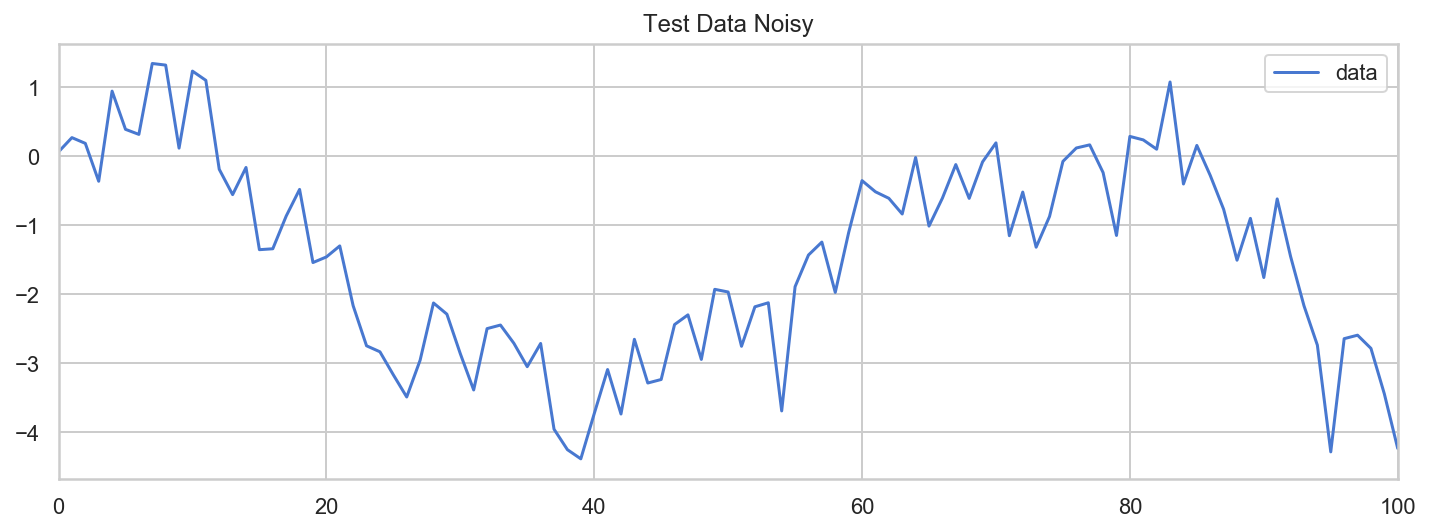

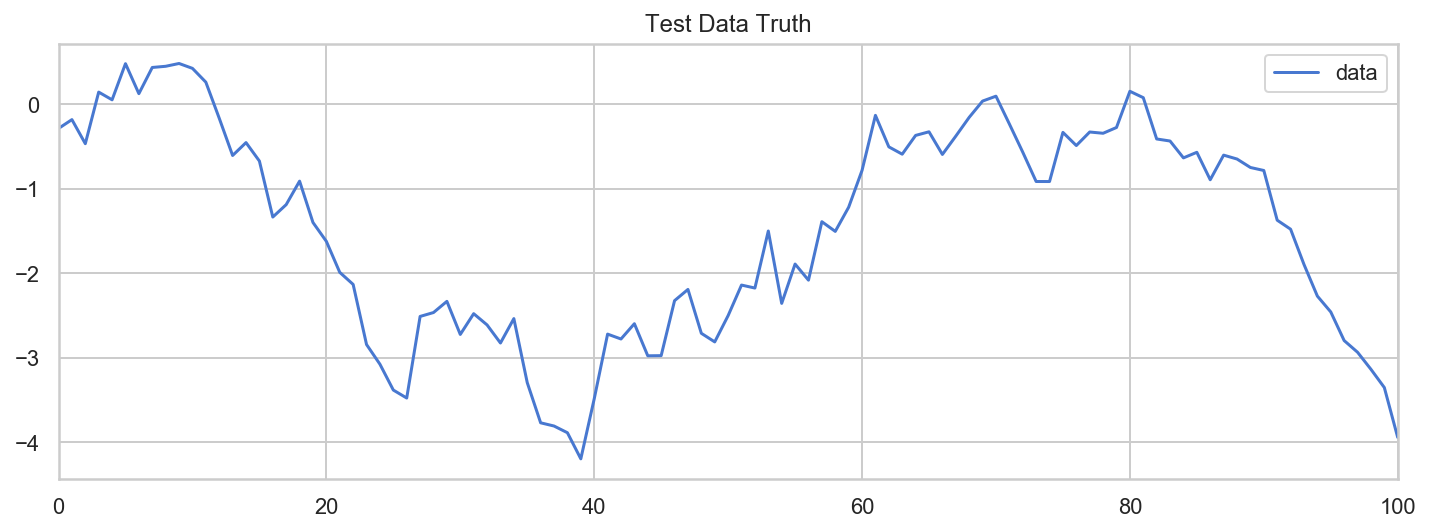

In [70]:
noisy_obs.plot(figsize=(12,4))
plt.title("Test Data Noisy")
truth_obs.plot(figsize=(12,4))
plt.title("Test Data Truth")

In [71]:
pf = ParticleFilter(noisy_obs.data.values, truth_obs.data.values, n_particle, sigma_2, alpha_2)

In [72]:
pf.simulate()

calculating... t=0C:\Users\yuuya\Anaconda3\envs\sotsuron\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in sqrt
  # This is added back by InteractiveShellApp.init_path()
C:\Users\yuuya\Anaconda3\envs\sotsuron\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in less
  
 calculating... t=100

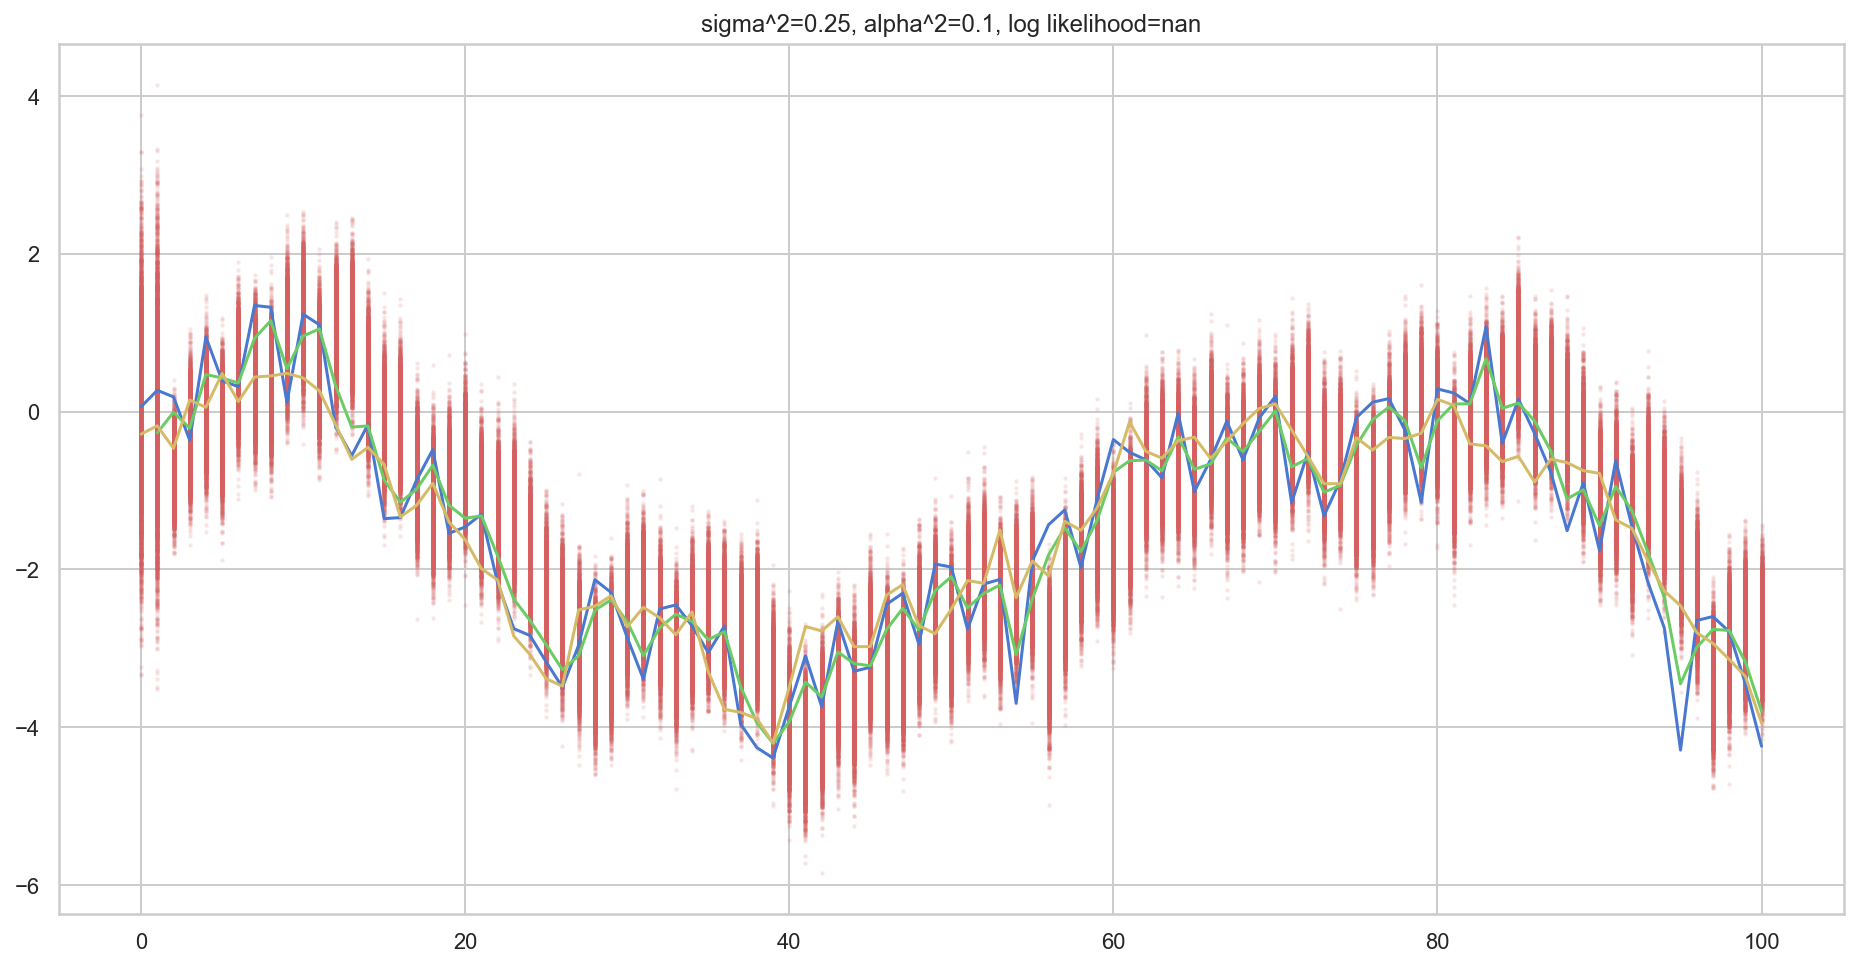

In [73]:
pf.draw_graph()

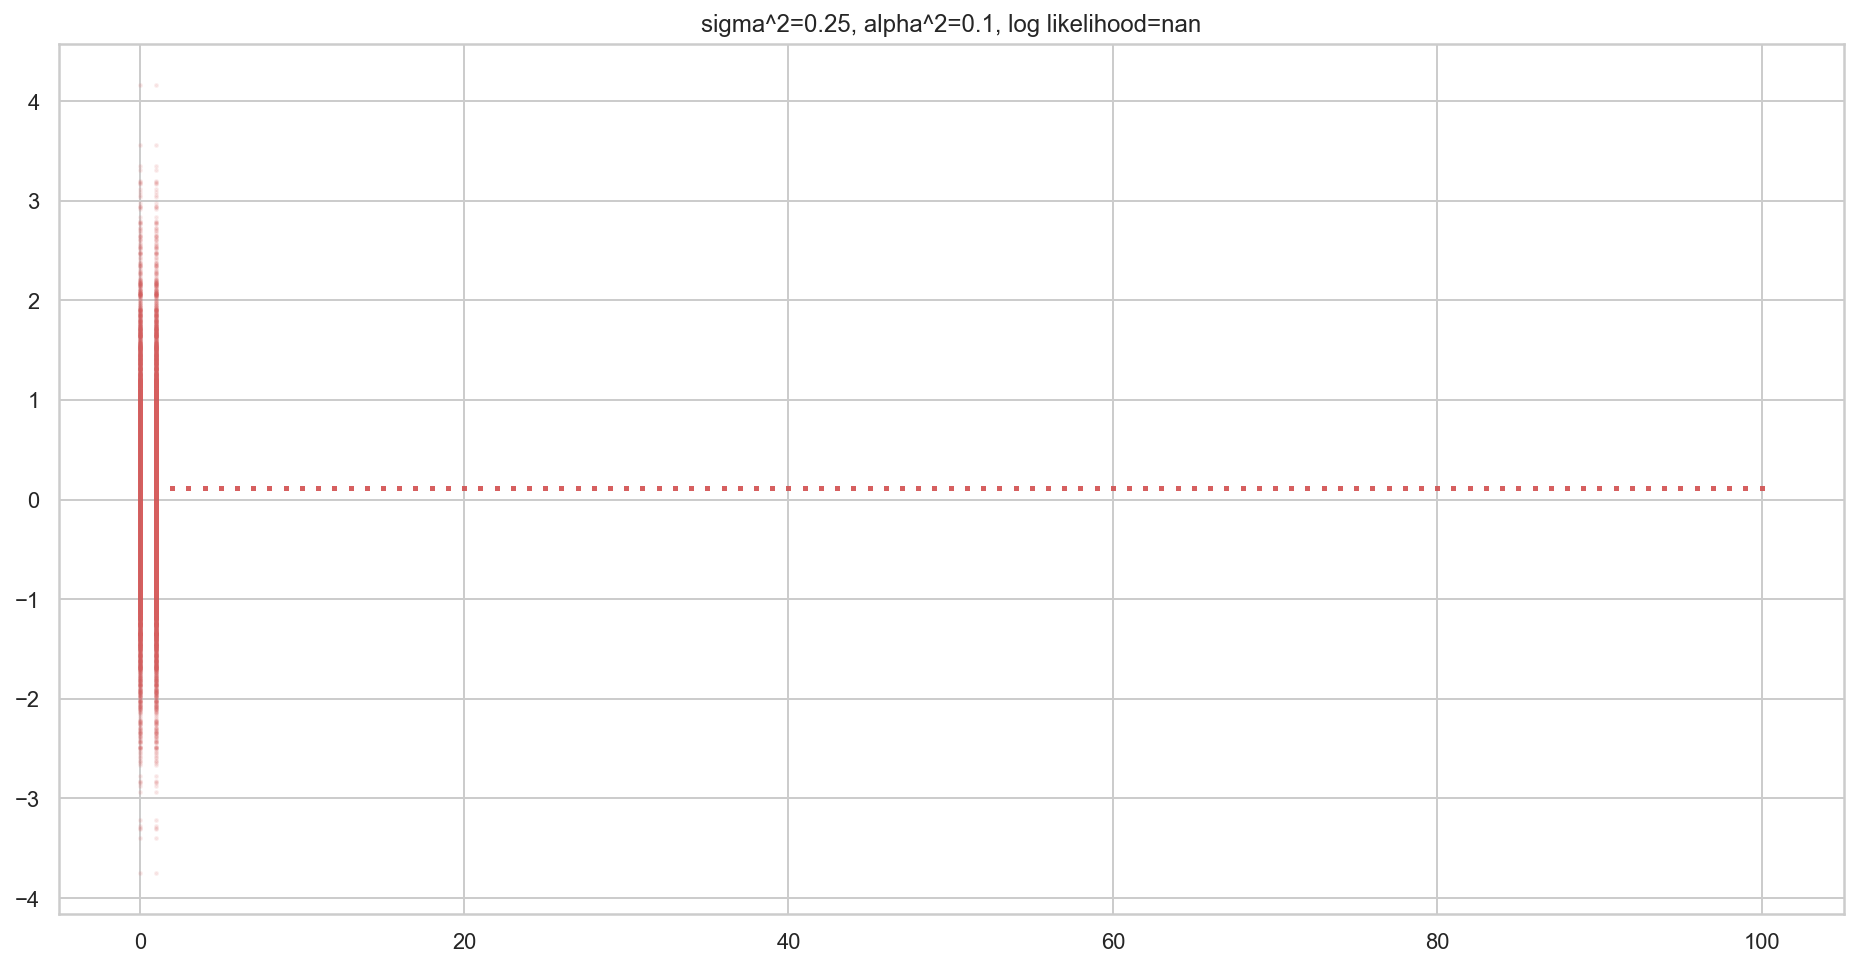

In [74]:
pf.draw_graph_parameter()

### カルマンフィルターと見比べる

                        Unobserved Components Results                         
Dep. Variable:                      y   No. Observations:                  100
Model:                    local level   Log Likelihood                 -78.631
Date:                Mon, 21 Oct 2019   AIC                            161.261
Time:                        00:51:23   BIC                            166.452
Sample:                             0   HQIC                           163.361
                                - 100                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular     0.2062      0.039      5.235      0.000       0.129       0.283
sigma2.level         0.0216      0.012      1.802      0.072      -0.002       0.045
Ljung-Box (Q):              

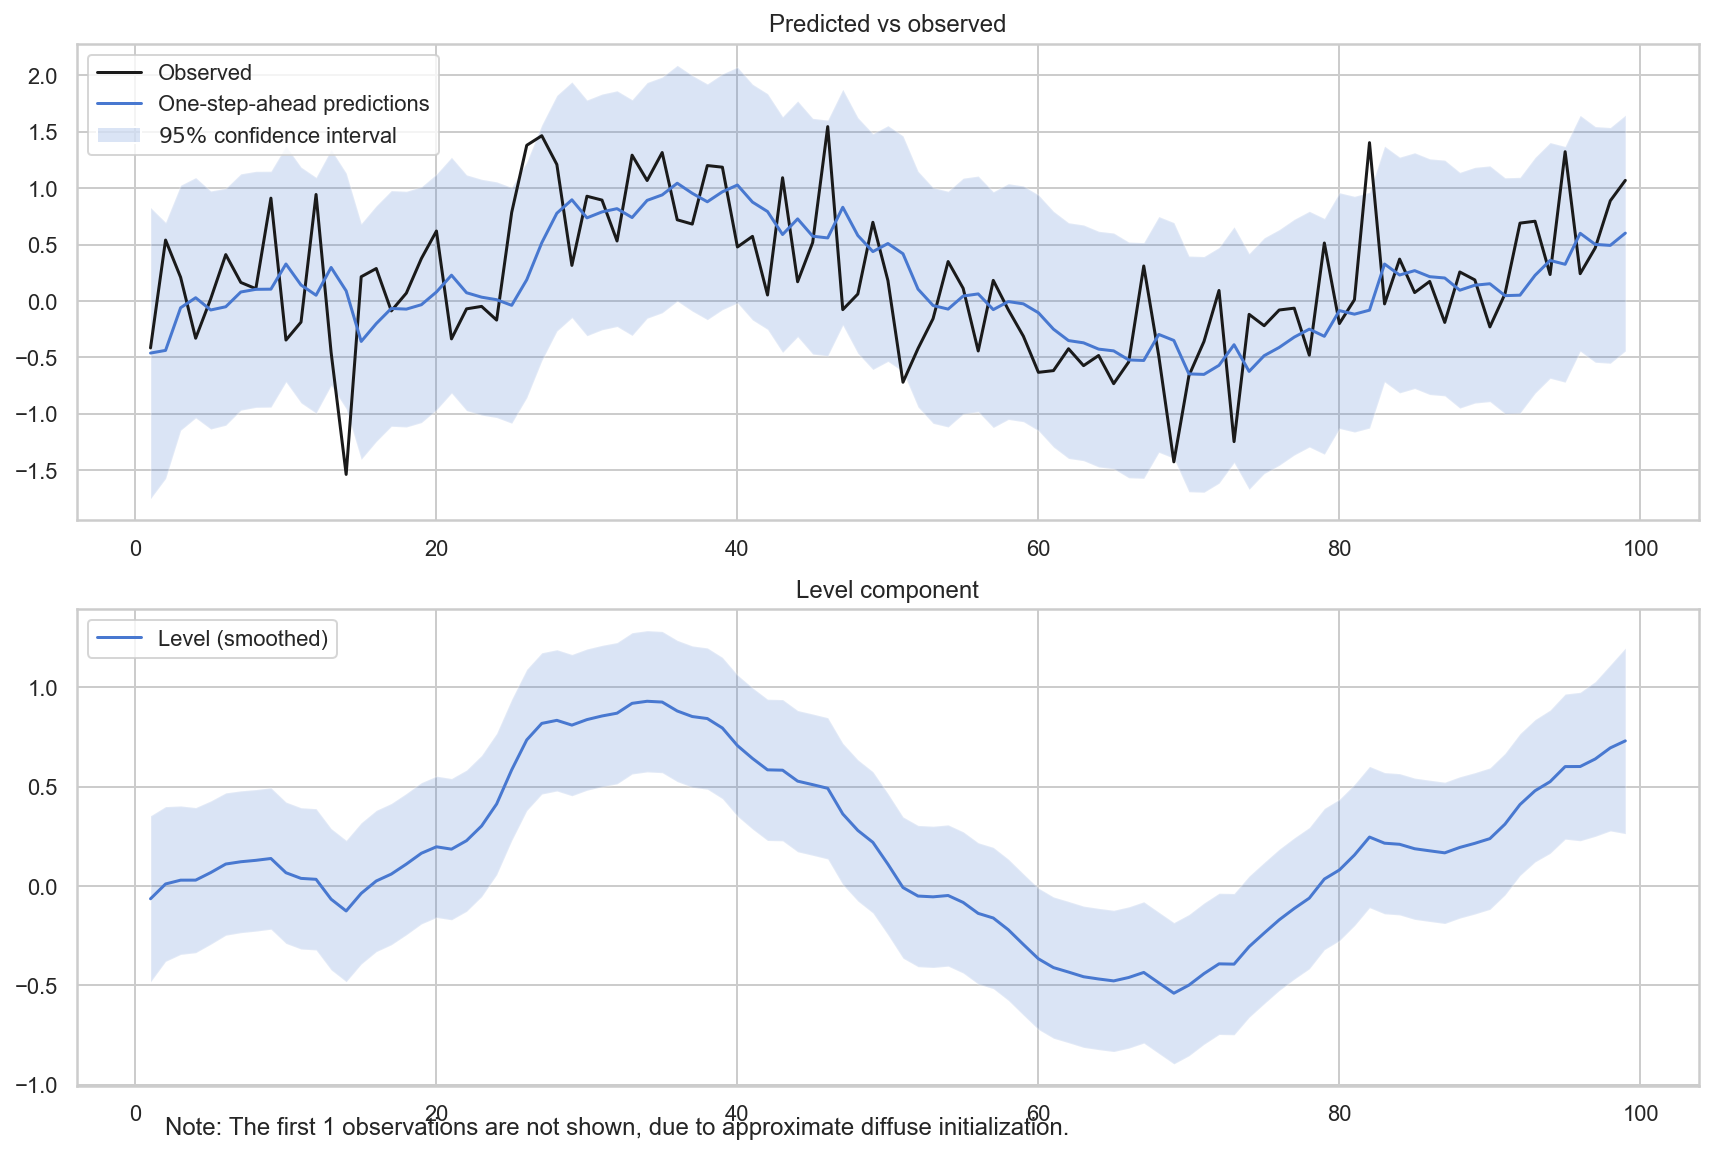

In [11]:
# Unobserved Components Modeling (via Kalman Filter)の実行
import statsmodels.api as sm

# Fit a local level model
mod_ll = sm.tsa.UnobservedComponents(df.data.values, 'local level')
res_ll = mod_ll.fit()

print(res_ll.summary())

# Show a plot of the estimated level and trend component series
fig_ll = res_ll.plot_components(legend_loc="upper left", figsize=(12,8))
plt.tight_layout()

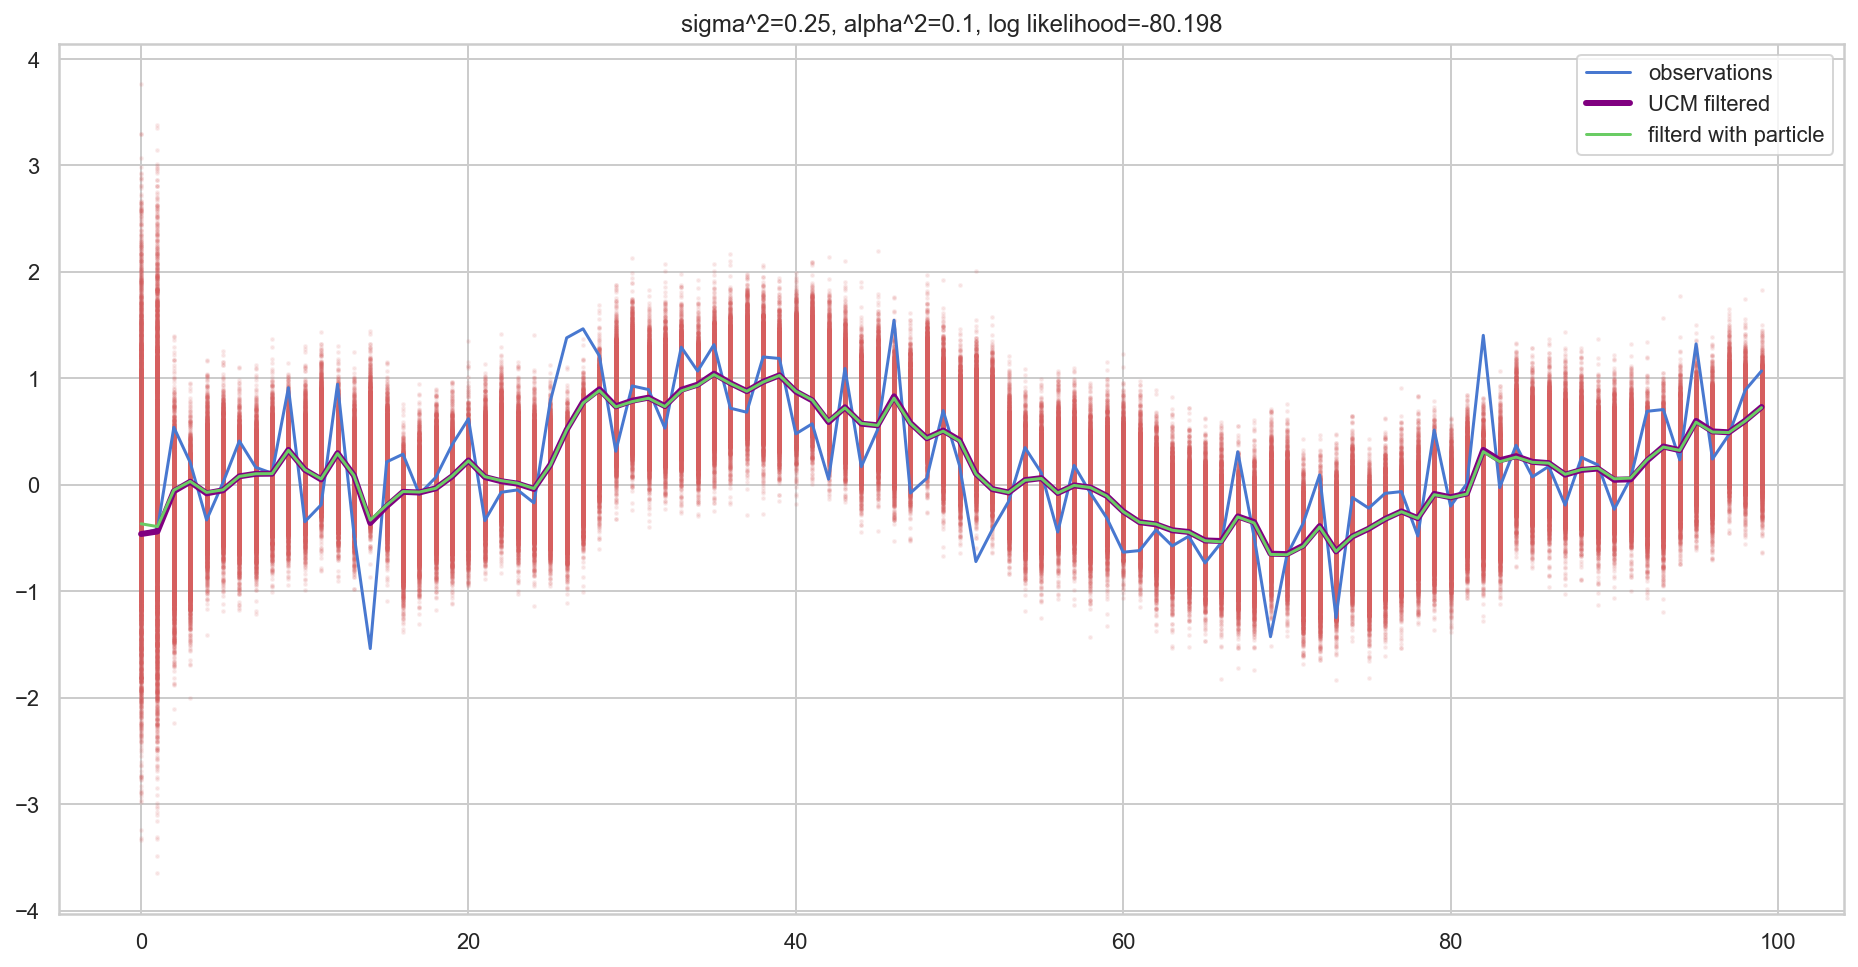

In [12]:
T = len(pf.y)

plt.figure(figsize=(16,8))
plt.plot(range(T), pf.y, label="observations")

plt.plot(res_ll.filtered_state.reshape(res_ll.filtered_state.shape[1]), "purple", lw=3, label="UCM filtered")
plt.plot(pf.get_filtered_value(), "g" ,label="filterd with particle")
for t in range(T):
    plt.scatter(np.ones(pf.n_particle)*t, pf.x[t], color="r", s=2, alpha=0.1)
plt.title("sigma^2={0}, alpha^2={1}, log likelihood={2:.3f}".format(pf.sigma_2, 
                                                                    pf.alpha_2, 
                                                                    pf.log_likelihood))
plt.legend(loc="best")
plt.show()

### ハイパーパラメータGrid Search

In [12]:
n_particle = 10**3
result_list = []
a_list = []
b_list = []
likelihood_list = []

for a in range(-8, 2):
    for b in range(-5, 6):
        sigma_2 = 2**a
        alpha_2 = 10**b
        pf = ParticleFilter(df.data.values, n_particle, sigma_2, alpha_2)
        pf.simulate()
        result_list.append(pf)
        print("")
        print(a, b, pf.log_likelihood)
        a_list.append(a)
        b_list.append(b)
        likelihood_list.append(pf.log_likelihood)

 calculating... t=99
-8 -5 -7611.96044829
 calculating... t=99
-8 -4 -7416.53359591
 calculating... t=99
-8 -3 -6945.7114457
 calculating... t=99
-8 -2 -5492.1615875
 calculating... t=99
-8 -1 -3489.9900233
 calculating... t=99
-8 0 -2025.10821314
 calculating... t=99
-8 1 -650.05245491
 calculating... t=99
-8 2 -99.5367503165
 calculating... t=99
-8 3 -166.346823516
 calculating... t=99
-8 4 -283.622339388
 calculating... t=99
-8 5 -404.570092007
 calculating... t=99
-7 -5 -3448.12851164
 calculating... t=99
-7 -4 -3601.86134724
 calculating... t=99
-7 -3 -3122.54848171
 calculating... t=99
-7 -2 -2422.72110264
 calculating... t=99
-7 -1 -1550.19261254
 calculating... t=99
-7 0 -852.610950039
 calculating... t=99
-7 1 -235.441257896
 calculating... t=99
-7 2 -108.901770598
 calculating... t=99
-7 3 -198.282423033
 calculating... t=99
-7 4 -314.256264291
 calculating... t=99
-7 5 -433.501336021
 calculating... t=99
-6 -5 -1394.77623755
 calculating... t=99
-6 -4 -1489.70717387
 calcula

In [13]:
idx = np.argmax(likelihood_list)
print("argmax idx:", idx)

print("likelihood={}, a:{}, b={}".format(likelihood_list[idx], a_list[idx], b_list[idx]))

argmax idx: 70
likelihood=-80.18725241309176, a:-2, b=-1


In [ ]:
n_particle = 10**3
result_list = []
a_list = []
b_list = []
likelihood_list = []

for a in range(-8, 2):
    for b in range(-5, 6):
        sigma_2 = 2**a
        alpha_2 = 10**b
        pf = ParticleFilter(df.data.values, n_particle, sigma_2, alpha_2)
        pf.simulate()
        result_list.append(pf)
        print("")
        print(a, b, pf.log_likelihood)
        a_list.append(a)
        b_list.append(b)
        likelihood_list.append(pf.log_likelihood)